https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V2: outputs variable # of patches according to input

# Attention Map

In [56]:
# CONFIG
# model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
model_name = "depth-anything/Depth-Anything-V2-Small-hf"
# https://huggingface.co/docs/transformers/main/model_doc/depth_anything_v2
data_dir = "/Users/ms/cs/ML/SingleImageINR/data"

target_image = "ct_chest_1.jpeg"
# target_image = "ct_chest_2.png"
# target_image = "ct_chest_3.jpeg"
# target_image = "ct_dental_1.png"
# target_image = "ct_dental_2.png"
# target_image = "ct_bone_1.jpg"
# target_image = "ct_bone_2.jpeg"
# target_image = "ct_abdomen_1.png"

##### Natural Images #####
# target_image = "_dog.jpg"
# target_image = "_cat.png"
# target_image = "_hen.jpg"
# target_image = "_flamingo.jpg"

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# from transformers import AutoImageProcessor, AutoModel
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from transformers.image_utils import load_image
import os

In [58]:
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")

# Load model & image
processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name, output_attentions=True)
model = AutoModelForDepthEstimation.from_pretrained(
    model_name, output_attentions=True, output_hidden_states=True
).to(device)


image = load_image(os.path.join(data_dir, target_image))
# inputs = processor(images=image, return_tensors="pt").to(device)

# image = image.resize((image.size[0]//2, image.size[1]//2))
# image = image.resize((512, 512))
image = image.resize((768, 768))
image.size

Using device: cpu


(768, 768)

In [59]:
inputs = processor(
    images=image,
    do_resize=False,       # 🔹 disable forced 224 resize
    do_center_crop=False,  # 🔹 skip center crop
    return_tensors="pt"
).to(device)
inputs.pixel_values.shape

/Users/ms/anaconda3/envs/sio/lib/python3.10/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `DPTImageProcessor.preprocess` and were ignored: 'do_center_crop'
  return self.preprocess(images, **kwargs)


torch.Size([1, 3, 768, 768])

In [60]:
with torch.no_grad():
    # outputs = model(**inputs)
    # outputs = model(**inputs, interpolate_pos_encoding=True)
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)



# attentions = outputs.attentions
# num_layers = len(attentions)
# batch_size, num_heads, seq_len, _ = attentions[-1].shape
# num_registers = model.config.num_register_tokens
# patch_h = patch_w = int(np.sqrt(seq_len - 1 - num_registers))

# print(f"{num_layers} layers, {num_heads} heads, {patch_h}x{patch_w} patches")

# attentions = outputs.attentions
# num_layers = len(attentions)
# batch_size, num_heads, seq_len, _ = attentions[-1].shape
# num_registers = model.config.num_register_tokens
# patch_h = patch_w = int(np.sqrt(seq_len - 1 - num_registers))

attentions = outputs.attentions
num_layers = len(attentions)
batch_size, num_heads, seq_len, _ = attentions[-1].shape
# num_registers = model.config.num_register_tokens

# derive true patch grid from input image
_, _, H, W = inputs["pixel_values"].shape
patch_size = model.config.patch_size
patch_h = H // patch_size
patch_w = W // patch_size

print(f"{num_layers} layers, {num_heads} heads, {patch_h}x{patch_w} patches")


12 layers, 6 heads, 54x54 patches


In [61]:
# --- Raw CLS token self-attention (final layer only) ---
# Extract the last layer attention
last_attn = attentions[-1]  # shape: [B, num_heads, N, N]

# Average over heads
avg_attn = last_attn.mean(dim=1)[0]  # [N, N]

# Slice out CLS → patch attentions
# cls_attn = avg_attn[0, 1 + num_registers:]  # skip CLS + register tokens
cls_attn = avg_attn[0, 1:]  # skip CLS + register tokens
cls_attn = cls_attn.reshape(patch_h, patch_w).detach().cpu().numpy()

# Normalize to [0, 1]
cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min())

In [62]:
# Attention Rollout (multiplies the attention matrices across layers)
# def attention_rollout(attentions):
#     rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device) # initial “attention flow” (no influence yet).
#     for attn in attentions:
#         attn_fused = attn.mean(dim=1)  # Averages over the num_heads dimension
#         attn_fused += torch.eye(attn_fused.size(-1)).to(attn_fused.device)  # A + I # simulates residual connections in transformers
#         attn_fused /= attn_fused.sum(dim=-1, keepdim=True) # keeps the attention distribution valid
#         rollout = rollout @ attn_fused # Matrix multiplication → propagates the attention flow
#     return rollout
# rollout = attention_rollout(attentions)[0]

In [63]:
# CLS → Patch attention
# cls_attn = rollout[0, 1 + num_registers:]  # CLS → patch
# cls_attn = cls_attn.reshape(patch_h, patch_w).cpu().numpy()
# cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min())

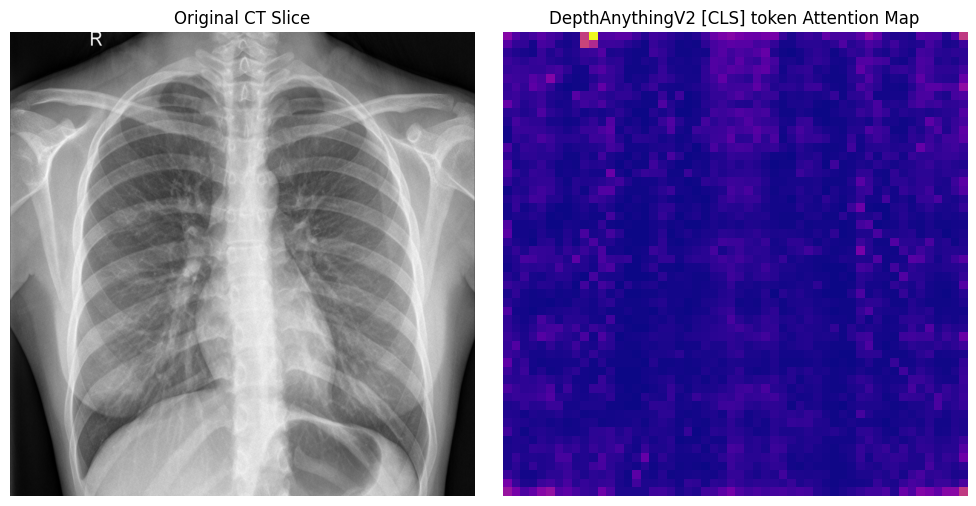

In [64]:
# Side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: Original Image
axes[0].imshow(image)
axes[0].set_title("Original CT Slice")
axes[0].axis("off")

# Right: Blocky Attention Map (no smoothing)
im = axes[1].imshow(cls_attn, cmap="plasma", interpolation="nearest")
# im = axes[1].imshow(cls_attn, cmap="plasma", interpolation="bilinear")
axes[1].set_title("DepthAnythingV2 [CLS] token Attention Map")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Patch Similarity Map

In [65]:
# Extract the last hidden state (flattened patch embeddings)
feats = outputs.hidden_states[-1].squeeze(0)  # [num_patches, hidden_dim]
print(feats.shape)

# No need to permute — it's already [N_patches, D]
# Remove CLS token
patch_feats = feats.cpu().numpy()
patch_feats = patch_feats[1:, :]  # drop the first token

# Compute patch grid dimensions
num_patches = patch_feats.shape[0]
patch_side = int(np.sqrt(num_patches))
print(f"Feature grid: {patch_side}x{patch_side}, dim={patch_feats.shape[1]}")

num_patches = patch_feats.shape[0]
patch_side = int(num_patches ** 0.5)


torch.Size([2917, 384])
Feature grid: 54x54, dim=384


In [66]:
# Create a grid of query patch indices (e.g., 4×4 evenly spaced)
grid_size = 4
coords = np.linspace(0, patch_side - 1, grid_size, dtype=int)
query_indices = [y * patch_side + x for y in coords for x in coords]

n_queries = len(query_indices)
cols = grid_size
rows = grid_size
print(cols, rows)

4 4


In [67]:
# # Prepare figure (original image + similarity maps)
# fig, axes = plt.subplots(rows, cols + 1, figsize=(4 * (cols + 1), 4 * rows))

# # ---- Left column: original image ----
# for r in range(rows):
#     ax_img = axes[r, 0]
#     ax_img.imshow(image)
#     ax_img.axis("off")
#     # mark all query patch centers as red dots
#     for q_idx in query_indices:
#         qy, qx = divmod(q_idx, patch_side)
        
#         patch_size = model.config.patch_size  # e.g., 16
#         img_w, img_h = image.size

#         # coordinates of patch centers in model space
#         center_x = (qx + 0.5) * patch_size
#         center_y = (qy + 0.5) * patch_size

#         # scale to original image size (in case it's not exactly 224x224)
#         scale_x = img_w / (patch_side * patch_size)
#         scale_y = img_h / (patch_side * patch_size)

#         ax_img.scatter(center_x * scale_x,
#                     center_y * scale_y,
#                     color="red", s=30, marker="o", edgecolors="black", linewidth=0.5, alpha=0.8)

# # ---- Right grid: similarity maps ----
# ax_list = []
# for r in range(rows):
#     for c in range(1, cols + 1):
#         ax_list.append(axes[r, c] if rows > 1 else axes[c])

# for ax, q_idx in zip(ax_list, query_indices):
#     query_feat = patch_feats[q_idx:q_idx + 1]
#     sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
#     sim_map = sim.reshape(patch_side, patch_side).cpu().numpy()
#     sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())

#     ax.imshow(sim_map, cmap="plasma")
#     qy, qx = divmod(q_idx, patch_side)
#     ax.scatter(qx, qy, color="red", s=40, marker="o", edgecolors="black", linewidth=0.5)
#     ax.set_title(f"({qx}, {qy})", fontsize=10)
#     ax.axis("off")

# plt.suptitle("DepthAnythingV2 Patch Similarity", fontsize=16)
# plt.tight_layout()
# plt.show()


Patch grid: 54x54, queries: 16
(54, 54)


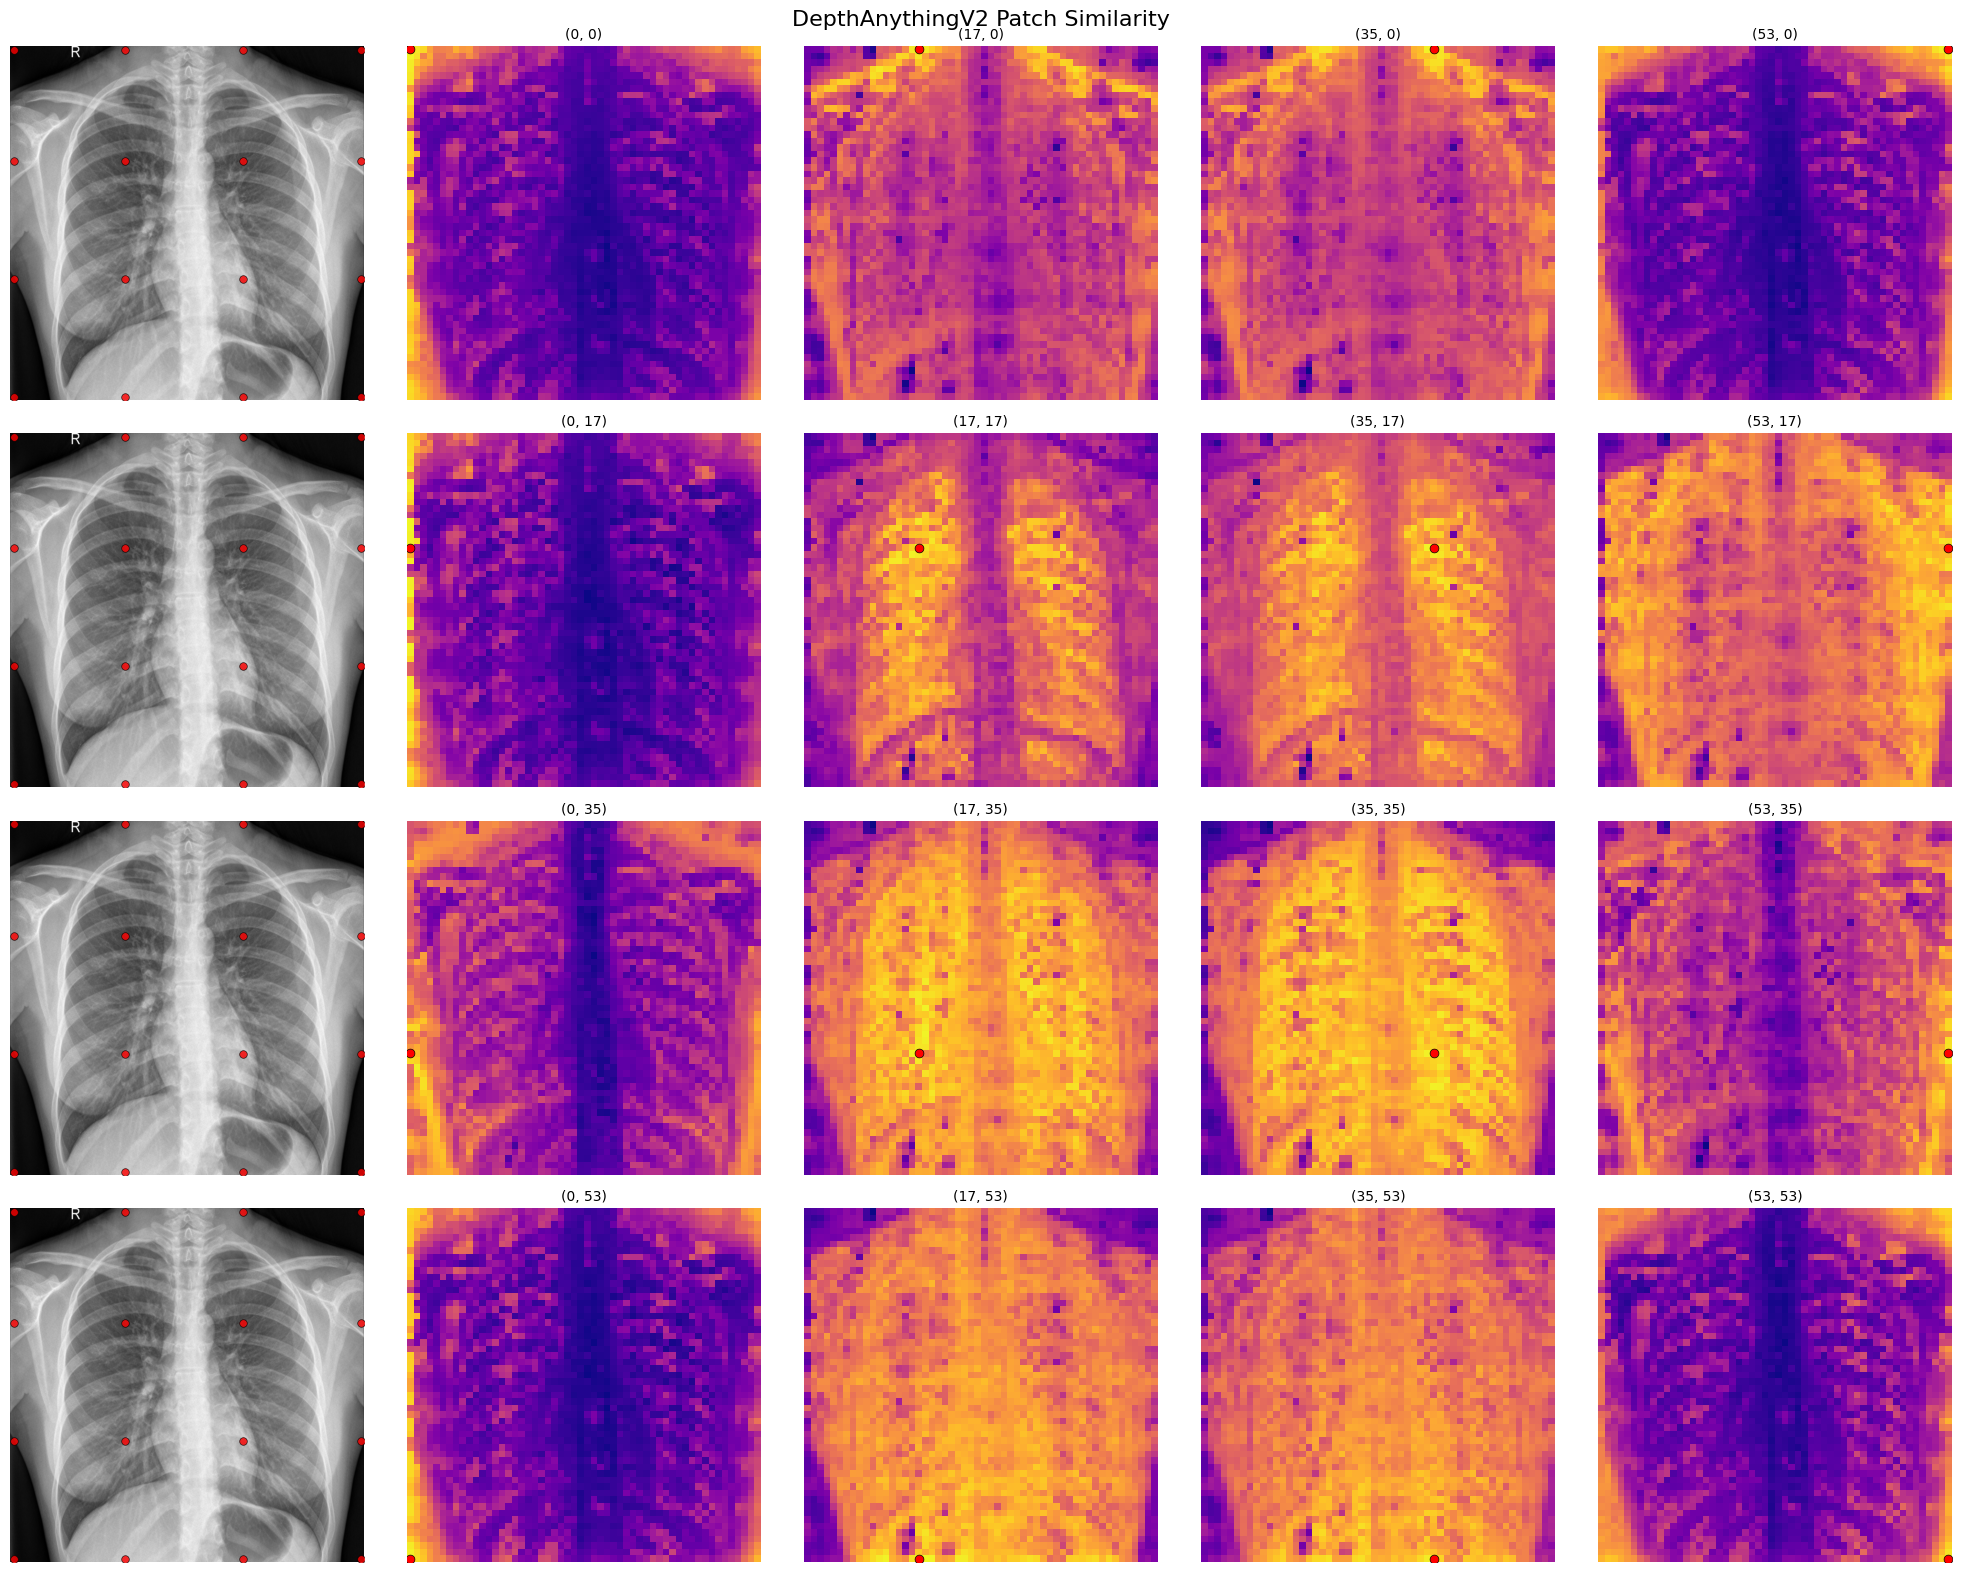

In [68]:
# Compute true patch grid from model input
_, _, H, W = inputs["pixel_values"].shape
patch_size = model.config.patch_size
patch_h, patch_w = H // patch_size, W // patch_size

# Confirm number of patches matches
num_patches = patch_feats.shape[0]
assert num_patches == patch_h * patch_w, f"Expected {patch_h*patch_w}, got {num_patches}"

# Create a grid of query patch indices (e.g., 4×4 evenly spaced)
grid_size = 4
coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

cols = grid_size
rows = grid_size
print(f"Patch grid: {patch_h}x{patch_w}, queries: {len(query_indices)}")

# ---- Figure setup ----
fig, axes = plt.subplots(rows, cols + 1, figsize=(4 * (cols + 1), 4 * rows))

# ---- Left column: original image ----
for r in range(rows):
    ax_img = axes[r, 0]
    ax_img.imshow(image)
    ax_img.axis("off")

    # mark all query patch centers
    for q_idx in query_indices:
        qy, qx = divmod(q_idx, patch_w)
        img_w, img_h = image.size
        center_x = (qx + 0.5) * (img_w / patch_w)
        center_y = (qy + 0.5) * (img_h / patch_h)
        ax_img.scatter(center_x, center_y,
                       color="red", s=30, marker="o",
                       edgecolors="black", linewidth=0.5, alpha=0.8)

# ---- Right grid: similarity maps ----
ax_list = []
for r in range(rows):
    for c in range(1, cols + 1):
        ax_list.append(axes[r, c] if rows > 1 else axes[c])

# for ax, q_idx in zip(ax_list, query_indices):
#     query_feat = patch_feats[q_idx:q_idx + 1]
#     sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
#     sim_map = sim.reshape(patch_h, patch_w).cpu().numpy()  # ✅ correct shape
#     sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())

#     qy, qx = divmod(q_idx, patch_w)
#     ax.imshow(sim_map, cmap="plasma", interpolation="nearest")
#     # ax.imshow(sim_map, cmap="plasma", interpolation="bilinear")
#     ax.scatter(qx, qy, color="red", s=40, marker="o",
#                edgecolors="black", linewidth=0.5)
#     ax.set_title(f"({qx}, {qy})", fontsize=10)
#     ax.axis("off")

# Convert numpy patch features to torch tensor
patch_feats_torch = torch.tensor(patch_feats, device=device, dtype=torch.float32)

for ax, q_idx in zip(ax_list, query_indices):
    query_feat = patch_feats_torch[q_idx:q_idx + 1]  # [1, dim]
    sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats_torch)  # [N_patches]
    sim_map = sim.reshape(patch_h, patch_w).cpu().numpy()
    sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())

    qy, qx = divmod(q_idx, patch_w)
    ax.imshow(sim_map, cmap="plasma", interpolation="nearest")
    ax.scatter(qx, qy, color="red", s=40, marker="o", edgecolors="black", linewidth=0.5)
    ax.set_title(f"({qx}, {qy})", fontsize=10)
    ax.axis("off")

print(sim_map.shape)
plt.suptitle("DepthAnythingV2 Patch Similarity", fontsize=16)
plt.tight_layout()
plt.show()


# PCA

In [69]:
from sklearn.decomposition import PCA

# patch_feats: [N_patches, hidden_dim], e.g., [3072, 384]
# feats = patch_feats.cpu().numpy()
feats = patch_feats

# Apply PCA → project hidden_dim → 3 components
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(feats)  # shape: [N_patches, 3]

# Normalize each PCA channel to [0, 1]
pca_min = pca_feats.min(axis=0, keepdims=True)
pca_max = pca_feats.max(axis=0, keepdims=True)
pca_norm = (pca_feats - pca_min) / (pca_max - pca_min + 1e-8)

# ✅ Get actual patch grid from input tensor
_, _, H, W = inputs["pixel_values"].shape
patch_size = model.config.patch_size
patch_h, patch_w = H // patch_size, W // patch_size

# Sanity check
num_patches = patch_feats.shape[0]
assert num_patches == patch_h * patch_w, f"Expected {patch_h*patch_w}, got {num_patches}"

# Reshape into correct patch grid (HxWx3)
pca_image = pca_norm.reshape(patch_h, patch_w, 3)

(54, 54, 3)


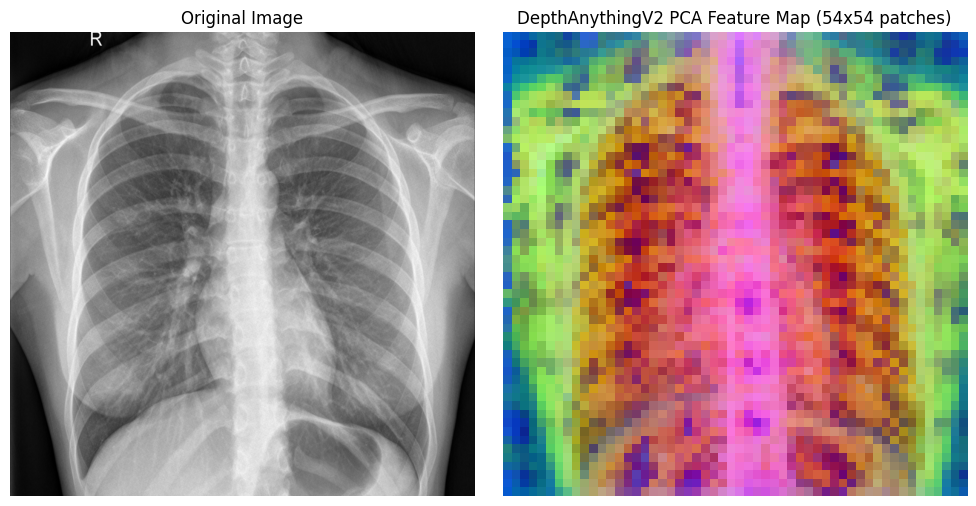

In [70]:
print(pca_image.shape)
# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(pca_image,interpolation="nearest")
# axes[1].imshow(pca_image,interpolation="bilinear")
axes[1].set_title(f"DepthAnythingV2 PCA Feature Map ({patch_h}x{patch_w} patches)")
axes[1].axis("off")

plt.tight_layout()
plt.show()